In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import tarfile
import re
import copy
import pickle
import argparse
import os.path
import sys
import time
import gzip
import configparser
import csv
import numpy as np

In [3]:
def load_data_mnist(dataset):
    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    f.close()

    n_in = 28
    in_channel = 1

    test_set_x, test_set_y = test_set
    valid_set_x, valid_set_y = valid_set
    train_set_x, train_set_y = train_set

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
    return rval, n_in, in_channel, 10


def load_data_cifar10(dataset):
    train_dic = dict()
    f = tarfile.open(dataset, 'r')
    for member in f.getmembers():
        match1 = re.search(r".*\/data_batch_.*", member.name)
        match2 = re.search(r".*\/test_batch", member.name)
        if match1 is not None:
            print("Training: extracting {} ...".format(member.name))
            ef = f.extractfile(member)
            train_tmp = pickle.load(ef, encoding='latin1')
            if bool(train_dic) is False:
                train_dic = train_tmp
            else:
                train_dic['data'] = np.append(train_dic['data'], train_tmp['data'], axis=0)
                train_dic['labels'] = np.append(train_dic['labels'], train_tmp['labels'], axis=0)
        elif match2 is not None:
            print("Testing/Validating: extracting {} ...".format(member.name))
            ef = f.extractfile(member)
            test_dic = pickle.load(ef, encoding='latin1')
            test_dic['labels'] = np.array(test_dic['labels'])
    f.close()

    n_in = 32
    in_channel = 3

    def shared_dataset(data_dic, borrow=True):
        data_x = data_dic['data'].astype(np.float32)
        data_x /= 255.0#data_x.max()
        data_y = data_dic['labels'].astype(np.int32)
        return data_x, data_y

    train_set_x, train_set_y = shared_dataset(train_dic)
    test_set_x, test_set_y = shared_dataset(test_dic)
    #valid_set_x, valid_set_y = shared_dataset(valid_dic)

    rval = [(train_set_x, train_set_y), (test_set_x, test_set_y), (test_set_x, test_set_y)]
    return rval, n_in, in_channel, 10

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as N
import matplotlib.pyplot as plt
import os
import numpy as np
input_path = os.path.join('/content/drive/MyDrive','MNIST_data/mnist.pkl.gz')
drive_path = os.path.join('/content/drive/myDrive')

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
OUTPUT_FOLDER = "output"
EXERCISE = "exercise_3"
OUTPUT_DIR = os.path.join(drive_path, OUTPUT_FOLDER)
# os.makedirs(OUTPUT_DIR, exist_ok=True)
N_EPOCHS = 30
LEARNING_RATE = 1E-4
BATCH_SIZE = 50
OUTPUT_DIR = os.path.join(OUTPUT_FOLDER, EXERCISE)

In [10]:

#read data from file
data_input = load_data_mnist(input_path)
#FYI data = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
data = data_input[0]
print ( N.shape(data[0][0])[0] )
print ( N.shape(data[0][1])[0] )

N_GPU = 1

#data layout changes since output should an array of 10 with probabilities
real_output = N.zeros( (N.shape(data[0][1])[0] , 10), dtype=N.float32 )
for i in range ( N.shape(data[0][1])[0] ):
  real_output[i][data[0][1][i]] = 1.0

#data layout changes since output should an array of 10 with probabilities
valid_check = N.zeros( (N.shape(data[1][1])[0] , 10), dtype=N.float32 )
for i in range ( N.shape(data[1][1])[0] ):
  valid_check[i][data[1][1][i]] = 1.0


#data layout changes since output should an array of 10 with probabilities
real_check = N.zeros( (N.shape(data[2][1])[0] , 10), dtype=N.float32 )
for i in range ( N.shape(data[2][1])[0] ):
  real_check[i][data[2][1][i]] = 1.0


#set up the computation. Definition of the variables.
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
y_ = tf.placeholder(tf.float32, [None, 10])



#declare weights and biases
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


#convolution and pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

#First convolutional layer: 32 features per each 5x5 patch
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


#Reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height.
#28x28 = 784
#The final dimension corresponding to the number of color channels.
x_image = tf.reshape(x, [-1, 28, 28, 1])


#We convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.
#The max_pool_2x2 method will reduce the image size to 14x14.

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Second convolutional layer: 64 features for each 5x5 patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


#Densely connected layer: Processes the 64 7x7 images with 1024 neurons
#Reshape the tensor from the pooling layer into a batch of vectors,
#multiply by a weight matrix, add a bias, and apply a ReLU.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#drop_out
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


#Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#Per_image_crossentropy
cross_entropy_local = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)

#Crossentropy
cross_entropy = tf.reduce_mean(cross_entropy_local)
# tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

50000
50000


Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

TRAINING
EPOCH 1/30 -- Loss 0.131067 -- Acc: 0.960580 -- Val Loss 0.120384 -- Val Acc 0.965200-- time: 28.072
EPOCH 2/30 -- Loss 0.076142 -- Acc: 0.976960 -- Val Loss 0.076965 -- Val Acc 0.977700-- time: 2.761
EPOCH 3/30 -- Loss 0.060090 -- Acc: 0.980980 -- Val Loss 0.066839 -- Val Acc 0.978800-- time: 2.749
EPOCH 4/30 -- Loss 0.042445 -- Acc: 0.986280 -- Val Loss 0.053605 -- Val Acc 0.983800-- time: 2.742
EPOCH 5/30 -- Loss 0.034413 -- Acc: 0.989200 -- Val Loss 0.051046 -- Val Acc 0.983700-- time: 2.745
EPOCH 6/30 -- Loss 0.027820 -- Acc: 0.991260 -- Val Loss 0.046694 -- Val Acc 0.986900-- time: 2.748
EPOCH 7/30 -- Loss 0.021522 -- Acc: 0.993400 -- Val Loss 0.041246 -- Val Acc 0.988300-- time: 2.770
EPOCH 8/30 -- Loss 0.016284 -- Acc: 0.995120 -- Val Loss 0.039596 -- Val Acc 0.989000-- time: 2.722
EPOCH 9/30 -- Loss 0.012

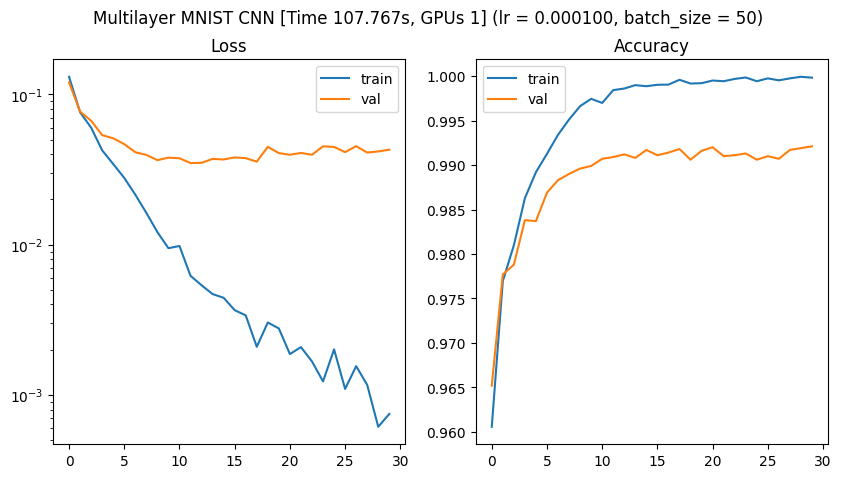

In [11]:
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("=====================================")
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
  sess.run(tf.global_variables_initializer())
  #TRAIN
  print("TRAINING")

  start_time = time.time()

  d_loss = {"train":[], "val":[]}
  d_acc = {"train":[], "val":[]}
  for epoch in range(1, N_EPOCHS+1):
    start_epoch_time = time.time()

    for i in range(len(data[0][0])//BATCH_SIZE):

      #until 1000 96,35%
      batch_ini = BATCH_SIZE*i
      batch_end = BATCH_SIZE*i+BATCH_SIZE

      for j in range(N_GPU):
        with tf.device('/gpu:%d' %j):
          batch_xs = data[0][0][batch_ini:batch_end]
          batch_ys = real_output[batch_ini:batch_end]

      train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

    train_loss = cross_entropy.eval(feed_dict={x: data[0][0], y_: real_output, keep_prob: 1.0})
    val_loss = cross_entropy.eval(feed_dict={x: data[1][0], y_: valid_check, keep_prob: 1.0})

    train_accuracy = accuracy.eval(feed_dict={x: data[0][0], y_: real_output, keep_prob: 1.0})
    val_accuracy = accuracy.eval(feed_dict={x: data[1][0], y_: valid_check, keep_prob: 1.0})
    print("EPOCH %d/%d -- Loss %.6f -- Acc: %.6f -- Val Loss %.6f -- Val Acc %.6f-- time: %.3f" %(epoch, N_EPOCHS, train_loss, train_accuracy, val_loss, val_accuracy, time.time() - start_epoch_time))

    d_acc["train"].append(train_accuracy)
    d_acc["val"].append(val_accuracy)

    d_loss["train"].append(train_loss)
    d_loss["val"].append(val_loss)

  training_time = time.time() - start_time
  print("Total Training Time: %.3f seconds" % (training_time))
  train_accuracy = accuracy.eval(feed_dict={x: data[2][0], y_: real_check, keep_prob: 1.0})
  print('test accuracy %.3f' %(train_accuracy))

# PLOT
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.ravel()
ax[0].plot(range(N_EPOCHS), d_loss["train"], label="train")
ax[0].plot(range(N_EPOCHS), d_loss["val"], label="val")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_yscale("log")
ax[1].plot(range(N_EPOCHS), d_acc["train"], label="train")
ax[1].plot(range(N_EPOCHS), d_acc["val"], label="val")
ax[1].set_title("Accuracy")
ax[1].legend()
fig.suptitle("Multilayer MNIST CNN [Time %.3fs, GPUs %d] (lr = %f, batch_size = %d)" %(training_time, N_GPU, LEARNING_RATE, BATCH_SIZE))
filename = f"multilayer_lr_{LEARNING_RATE}_bs_{BATCH_SIZE}_ngpu_{N_GPU}_epochs_{N_EPOCHS}".replace(".", "_") + ".png"

plt.savefig(filename, format="png", bbox_inches="tight")